In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2
import napari

import matplotlib.pyplot as plt

from cell_division.nets.transfer_learning import CNN
from util.data.dataset_cell import CellDataset
from util.data.dataset_nuclei import NucleiDataset
from util import values as v
from util.misc import visualizer as vis
from util.misc.colors import bcolors as bc

from sklearn.metrics import classification_report, confusion_matrix
from cell_division.layers.custom_layers import (
    ExtendedLSEPooling,
    extended_w_cel_loss
)

from cell_division.nets.cam import overlay_heatmap, CAM

# GPU config
from util.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator
)
plt.style.use('default')

import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


increase_gpu_memory()
set_gpu_allocator()

In [2]:
from skimage import morphology
from util.data import imaging
from util.data.dataset_ht import HtDataset
from filtering import cardiac_region as cr


class NucleiDataset(tf.keras.utils.Sequence):
    def __init__(self, specimen, tissue='myocardium', resize=(50, 50), verbose=1):
        def parse_centroids(centroid):
            centroid = centroid.replace('[', '').replace(']', '').split(',')
            x, y, z = int(centroid[0]), int(centroid[1]), int(centroid[2])
            return np.array([x, y, z])

        self.N_CLASSES = 3
        self.CLASS_NAMES = ['Prophase/Metaphase', 'Anaphase/Telophase', 'Interphase']
        self.CLASSES = ['0', '1', '2']

        self.specimen = specimen

        ds = HtDataset()
        self.features = ds.get_features(
            specimen, 'Nuclei', tissue, 
            verbose=verbose, filtered=True
        )
        self.cell_ids = self.features['cell_id']
        centroids = self.features['centroids']
        self.centroids = np.array([parse_centroids(c) for c in centroids])

        self.seg_path, _ = ds.read_specimen(
            specimen, 'Nuclei', 'Segmentation', 
            verbose=verbose, filtered=True
        )
        self.raw_path, _ = ds.read_specimen(
            specimen, 'Nuclei', 'RawImages', 
            verbose=verbose
        )

        self.seg_img = imaging.read_image(self.seg_path, verbose=verbose)
        self.raw_img = imaging.read_image(self.raw_path, verbose=verbose)

        self.resize = resize
        self.batch_size = 1

        if verbose:
            print(f'{bc.OKGREEN}Nuclei Dataset created successfully{bc.ENDC}')
            print(f'\t{bc.OKBLUE}Specimen: {bc.ENDC}{self.specimen}')
            print(f'\t{bc.OKBLUE}Tissue: {bc.ENDC}{tissue}')
            print(f'\t{bc.OKBLUE}Number of Nuclei: {bc.ENDC}{len(self.cell_ids)}')

    def __get_image(self, idx):        
        cell_id = self.cell_ids[idx]
        c = self.centroids[idx]

        # Crop cell region + dilatation
        margins = cr.get_cell_margins(self.seg_img, cell_id, ma=0)
        mask = self.seg_img[
            c[0]-25: c[0]+25, c[1]-25: c[1]+25,
            int(margins[0][2]): int(margins[1][2])
        ]
        mask = np.where(mask == cell_id, 255, 0).astype(np.uint8)
        mask_dilated = morphology.opening(mask, morphology.ball(3))

        # Remove empty z-slices
        non_empty_slices = [
            i for i in range(mask.shape[2]) 
            if np.any(mask[..., i])
        ]
        mask = mask[..., non_empty_slices]
        mask_dilated = mask_dilated[..., non_empty_slices]

        # Crop raw image
        img_cell = self.raw_img[
            c[0]-25: c[0]+25, c[1]-25: c[1]+25,
            int(margins[0][2]): int(margins[1][2])
        ]
        img_cell = img_cell[..., non_empty_slices]

        # Erse background
        img_cell_no_bg = np.where(mask_dilated == 0, 0, img_cell)

        # IQR filter ver intensity
        img_cell_no_bg, intensities, thr = imaging.iqr_filter(
            img_cell_no_bg, get_params=True, verbose=1
        )
        mask_dilated = mask_dilated[..., intensities > thr]
        return img_cell_no_bg, mask_dilated

    def __get_cell_id(self, idx):
        return self.cell_ids[idx]
    
    def get_id(self, idx):
        return self.__get_cell_id(idx)

    def __len__(self):
        return len(self.cell_ids)

    def __getitem__(self, item):
        img, mask = self.__get_image(item)
        return (
            img.astype(np.uint8),
            mask.astype(np.uint8),
            self.__get_cell_id(item)
        )

In [3]:
INPUT_SHAPE = (100, 100, 3)

In [4]:
model = CNN(
    base=tf.keras.applications.VGG16,
    input_shape=INPUT_SHAPE,
    n_classes=3
)
model.build_top(activation='softmax', b_type='CAM', pooling=ExtendedLSEPooling)
model.compile(
    lr=.001,
    loss=extended_w_cel_loss()
)

model.add_calibration_layers('matrix')
model.compile_calibrated_model()
# model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

Trainable variables:  2
W:0
b:0


In [5]:
model.load(
    '../models/cellular_division_models/calibrated/vgg16_nuclei_under_calibrated_matrix.h5',
    calibrated=True
)

In [6]:
specimen = '0806_E5'
ds = NucleiDataset(specimen, verbose=1)

	Found: 20190806_E5_cell_properties_radiomics_Nuclei_myocardium.csv

	Found: 20190806_E5_mask_all_myocardium.nii.gz

	Found: 20190806_E5_DAPI_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/Filtered/20190806_E5_mask_all_myocardium.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Nuclei/20190806_E5_DAPI_decon_0.5.nii.gz
Nuclei Dataset created successfully
	Specimen: 0806_E5
	Tissue: myocardium
	Number of Nuclei: 781


In [7]:
to_analyse = [
    5943, 9534, 18779, 2652, 3247, 5870,
    5052, 5517, 6986, 7187, 7133, 7181, 
    6357, 6298, 6465
]

res = []

model.check_calibration()

for i in range(len(ds)):
    cell_id = ds.get_id(i)
    if cell_id in to_analyse:
        img, mask, cell_id = ds[i]
        pred, preds, weights, areas, w_preds = model.predict3d_assessment(img, mask)
        
        print(f'Cell ID: {cell_id}')
        print(f'Prediction: {pred}')
        print(f'Predictions: {preds}')
        print(f'Weights: {weights}')
        print(f'Areas: {areas}')
        print(f'Weighted Prediction: {w_preds}')
        
        res.append({
            'cell_id': cell_id,
            'prediction': pred,
            'predictions': preds,
            'w_preds': w_preds,
            'weights': weights,
            'areas': areas,
            'img': img,
            'mask': mask
        })

Predicting over the calibrated model
IQR Threshold: 2.3252639999999993
Removing 7 z-slices
Cell ID: 2652
Prediction: 2
Predictions: [[0.10596998 0.09248617 0.8015439 ]
 [0.11603676 0.11700023 0.76696306]
 [0.10597003 0.09248627 0.80154365]
 [0.10596998 0.09248617 0.8015439 ]
 [0.10660401 0.09362584 0.7997701 ]
 [0.10599729 0.09250145 0.8015012 ]
 [0.50068665 0.14781153 0.35150182]
 [0.10696846 0.09286275 0.8001688 ]
 [0.10599905 0.09249828 0.8015027 ]
 [0.18402387 0.11687842 0.6990977 ]
 [0.10598074 0.09249202 0.80152726]
 [0.1067009  0.09339137 0.7999077 ]
 [0.6692913  0.13067742 0.20003133]
 [0.1105739  0.0972183  0.79220784]
 [0.10749011 0.0953391  0.7971708 ]
 [0.10597126 0.09248896 0.8015397 ]
 [0.10596998 0.09248617 0.8015439 ]
 [0.10596998 0.09248617 0.8015439 ]]
Weights: [0.00702875 0.02172524 0.03961661 0.06325879 0.0798722  0.09201278
 0.10031949 0.10159744 0.09648562 0.09073482 0.08115016 0.07092652
 0.05495208 0.04345048 0.03003195 0.01789137 0.00894569 0.        ]
Areas: [

In [8]:
df = pd.DataFrame(res)
df.to_csv(
    v.data_path + f'CellDivision/3d_assessment/{specimen}.csv', 
    index=False
)

for item in res:
    img = item['img']
    mask = item['mask']
    
    imaging.save_nii(
        img, v.data_path + f'CellDivision/3d_assessment/{specimen}_{item["cell_id"]}_img.nii'
    )
    imaging.save_nii(
        mask, v.data_path + f'CellDivision/3d_assessment/{specimen}_{item["cell_id"]}_mask.nii'
    )

For each inserted cell id plot the following:
- Original image stacks (z-slices)
- Mask stacks (z-slices)
- Predictions per slice
- Weights per slice
- Areas per slice
- Final prediction

Cell ID: 2652
Prediction: 2
Stacks: 18


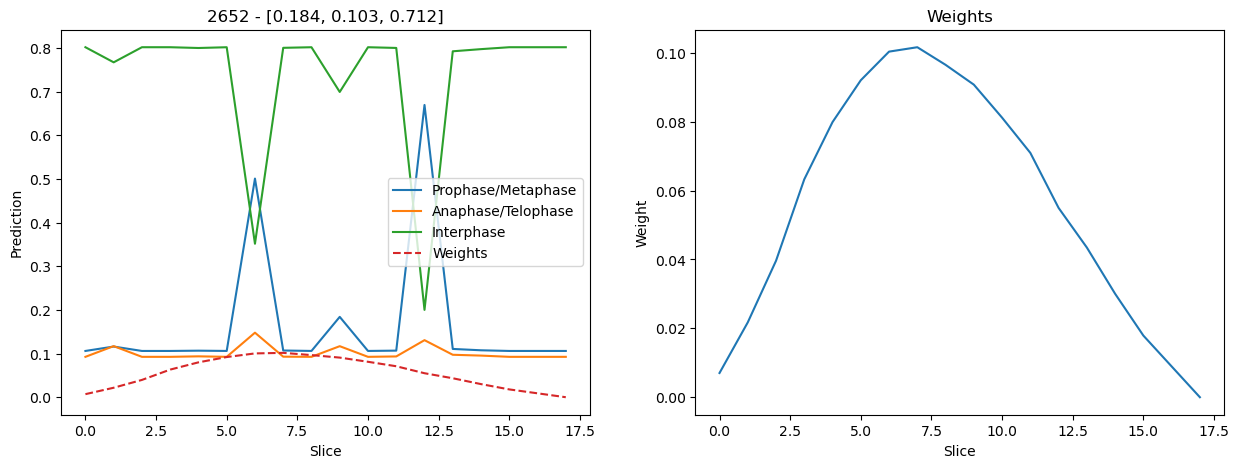

In [9]:
def plot_res(res: dict):
    img = res['img']
    mask = res['mask']
    cell_id = res['cell_id']
    pred = res['prediction']
    preds = res['predictions']
    weights = res['weights']
    areas = res['areas']
    w_preds = res['w_preds']
    
    print(f'Cell ID: {cell_id}')
    print(f'Prediction: {pred}')
    print(f'Stacks: {img.shape[2]}')

    # Plot predictions (shape = (z, 3))
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(preds[:, 0], label='Prophase/Metaphase')
    axs[0].plot(preds[:, 1], label='Anaphase/Telophase')
    axs[0].plot(preds[:, 2], label='Interphase')
    
    axs[0].plot(weights, label='Weights', linestyle='--')
    
    axs[0].set_title(f'{cell_id} - {[round(w, 3) for w in w_preds]}')
    axs[0].set_xlabel('Slice')
    axs[0].set_ylabel('Prediction')
    axs[0].legend()
    
    # Plot weights
    axs[1].plot(weights, label='Weights')
    axs[1].set_title('Weights')
    axs[1].set_xlabel('Slice')
    axs[1].set_ylabel('Weight')
    
    # # Plot areas
    # axs[2].plot(areas, label='Areas')
    # axs[2].set_title('Areas')
    # axs[2].set_xlabel('Slice')
    # axs[2].set_ylabel('Area')
    
    # Save figure
    plt.savefig(
        v.data_path + f'CellDivision/3d_assessment/{specimen}_{cell_id}.png'
    )
    
    plt.show()
        
plot_res(res[0])

Cell ID: 3247
Prediction: 2
Stacks: 13


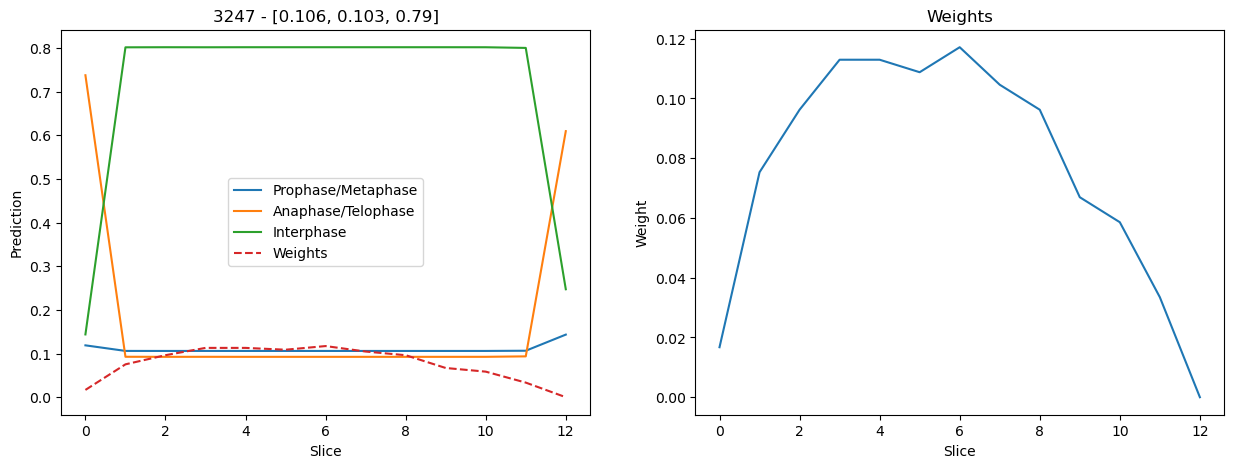

In [10]:
plot_res(res[1])

Cell ID: 5052
Prediction: 2
Stacks: 17


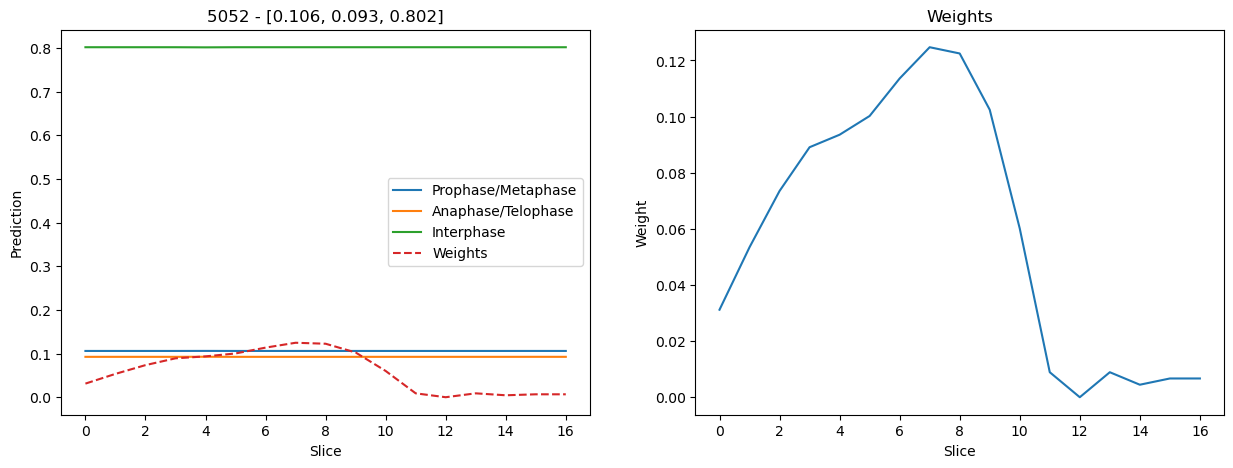

In [11]:
plot_res(res[2])

Cell ID: 5517
Prediction: 2
Stacks: 10


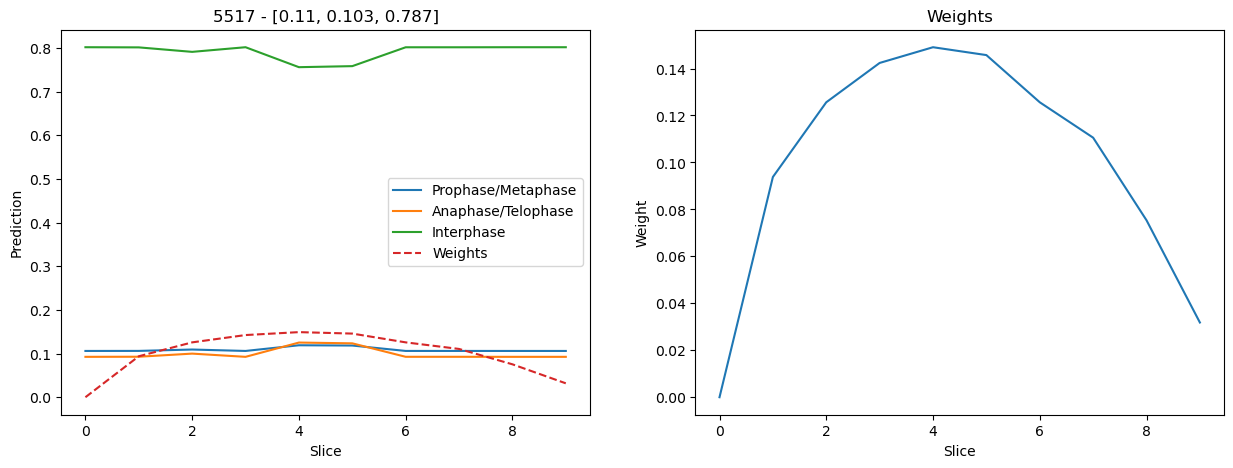

In [12]:
plot_res(res[3])

Cell ID: 5870
Prediction: 2
Stacks: 15


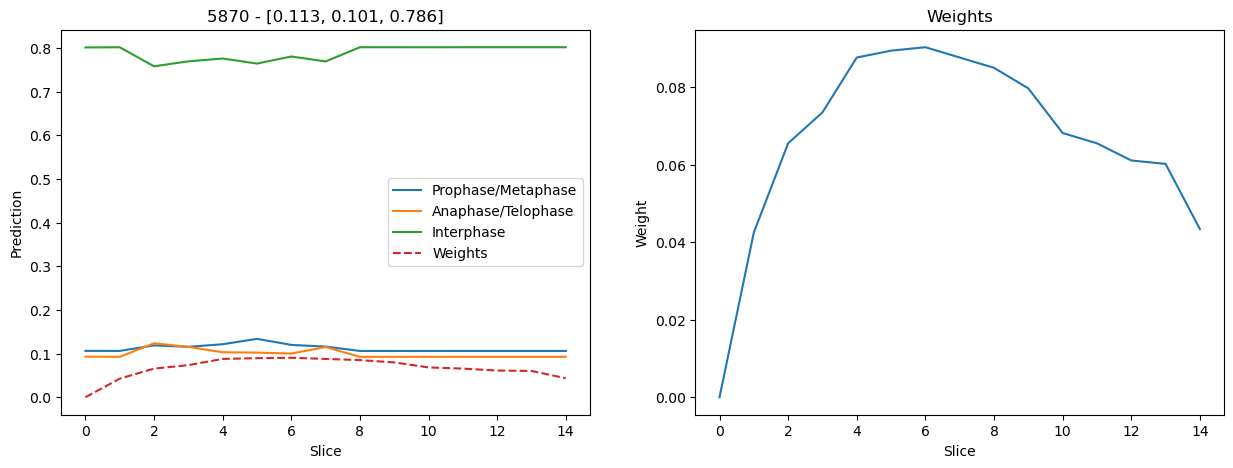

In [13]:
plot_res(res[4])

Cell ID: 5943
Prediction: 1
Stacks: 11


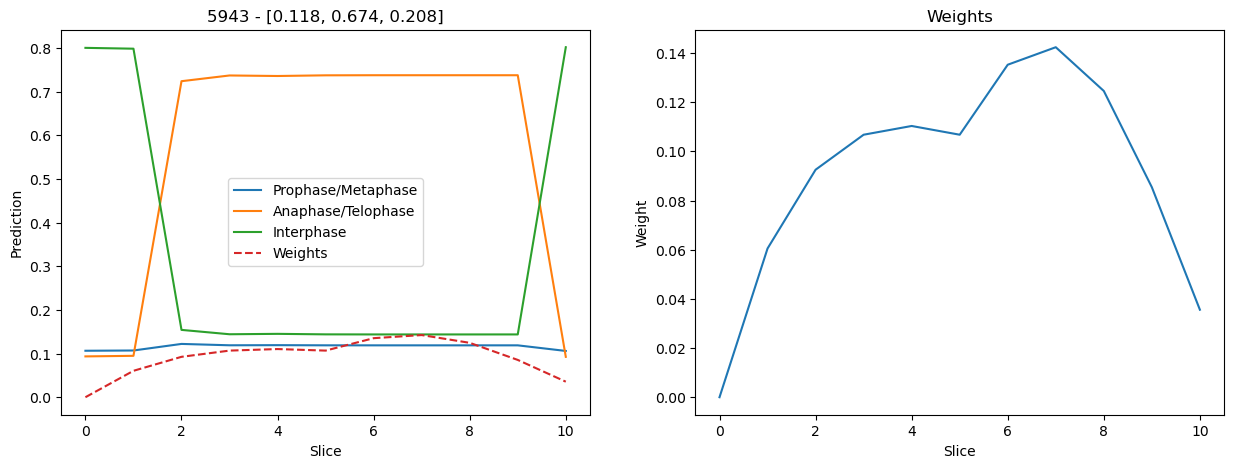

In [14]:
plot_res(res[5])

Cell ID: 6298
Prediction: 2
Stacks: 15


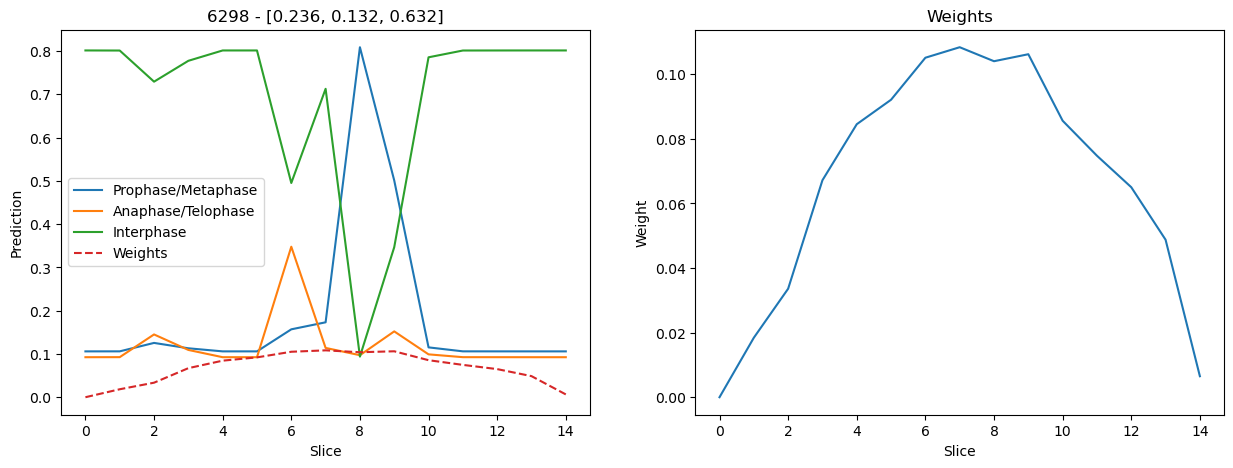

In [15]:
plot_res(res[6])

Cell ID: 6357
Prediction: 2
Stacks: 15


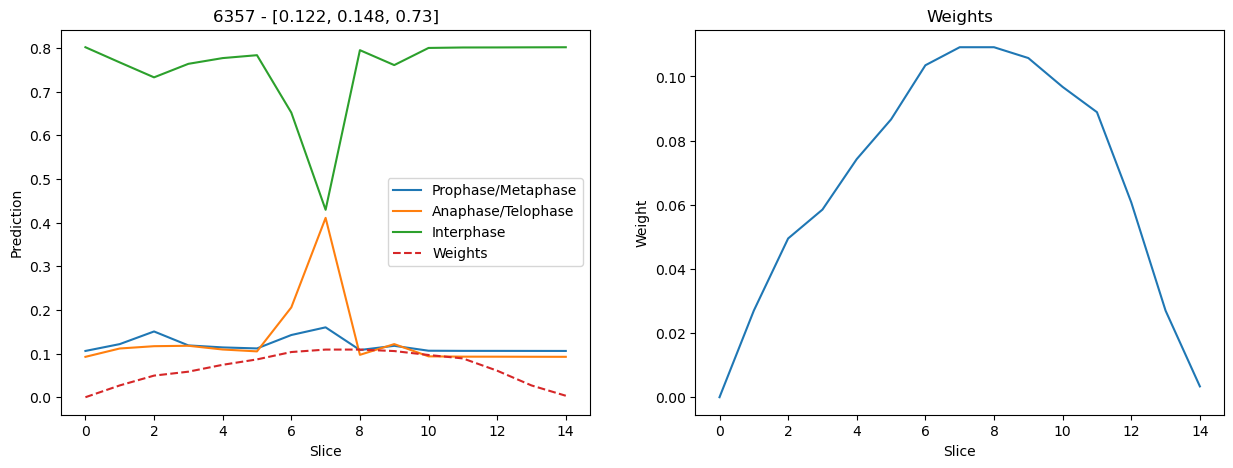

In [16]:
plot_res(res[7])

Cell ID: 6465
Prediction: 2
Stacks: 15


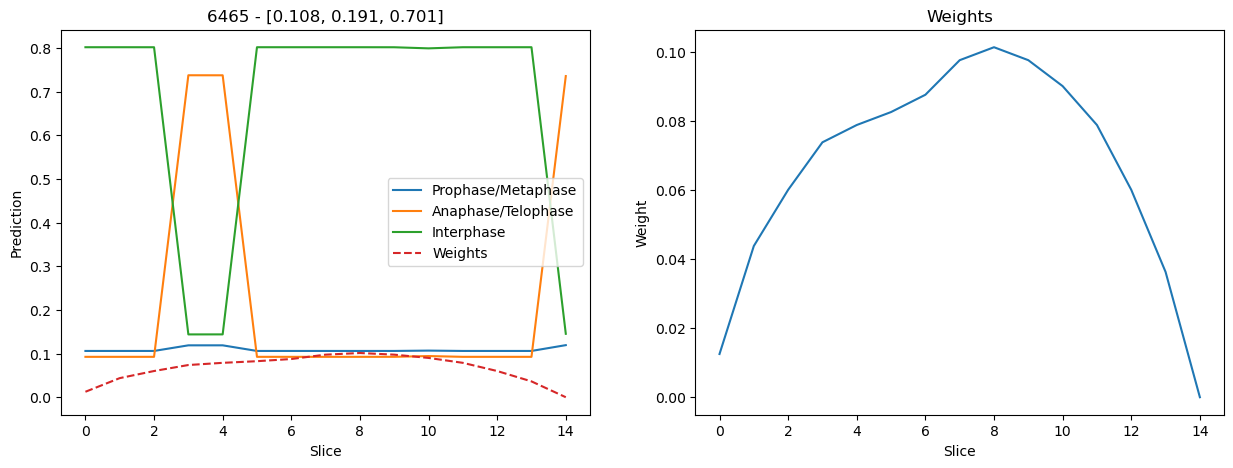

In [17]:
plot_res(res[8])

Cell ID: 6986
Prediction: 2
Stacks: 14


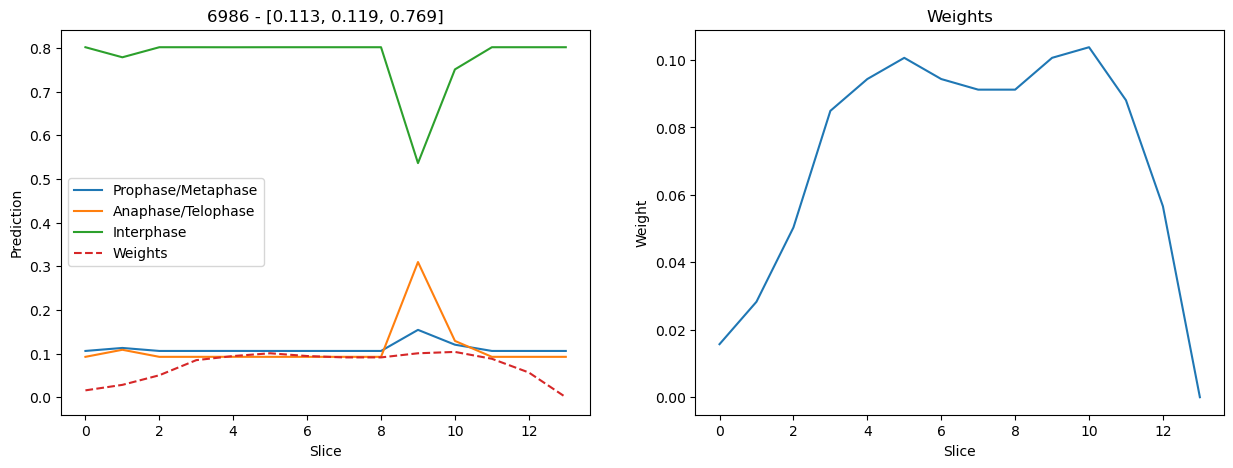

In [18]:
plot_res(res[9])

Cell ID: 7133
Prediction: 2
Stacks: 11


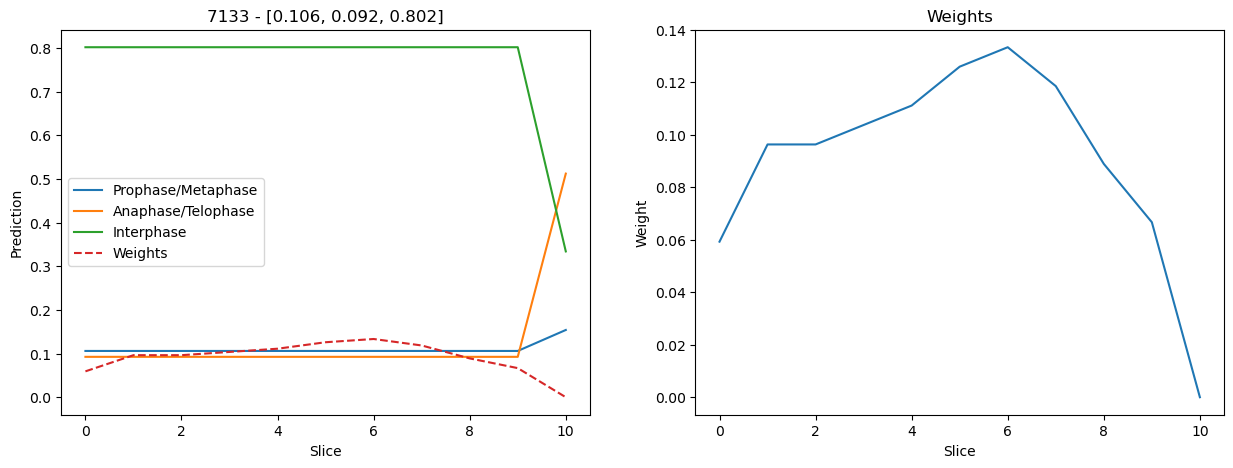

In [19]:
plot_res(res[10])

Cell ID: 7187
Prediction: 2
Stacks: 15


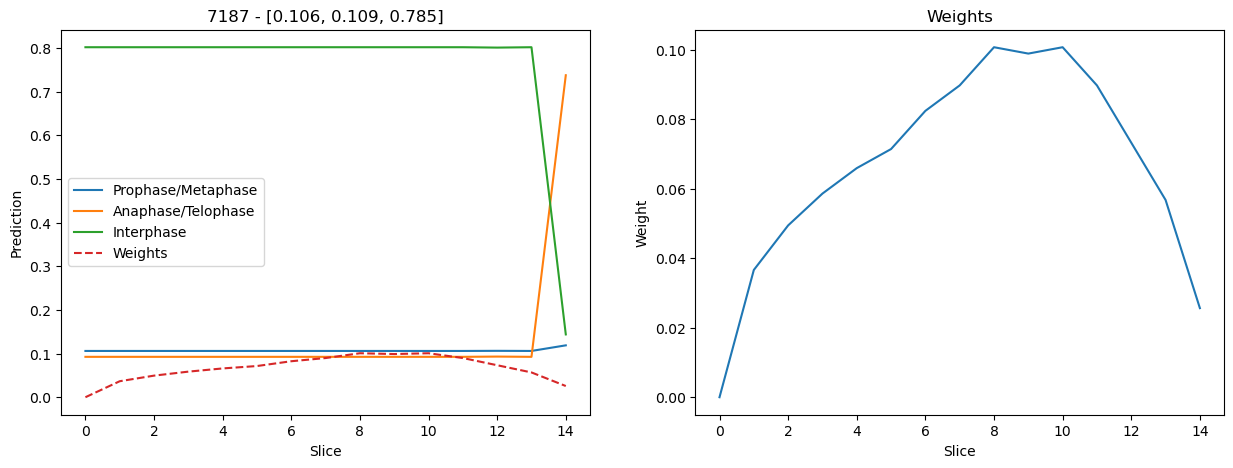

In [20]:
plot_res(res[12])